In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
class ClassificationAnalyser:
    def __init__(self,path,res_col=None,missing_data=[],categorical_data=[],label_encoding=[]):
        self.dataset = pd.read_csv(path)
        self.result = dict()
        if res_col is None:
            res_col = len(self.dataset.columns)-1
        self.X = self.dataset.iloc[:, [i for i in range(len(self.dataset.columns)) if i != res_col]].values
        self.y = self.dataset.iloc[:, res_col].values
        
        #updated categorical_data and label_encoding
        categorical_data = [i - 1 if i > res_col else i for i in categorical_data]
        label_encoding = [i - 1 if i > res_col else i for i in label_encoding]

        #missing data
        if missing_data:
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputer.fit(self.X[:, missing_data])
            self.X[:, missing_data] = imputer.transform(self.X[:, missing_data])
            
        #label encoding
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for i in label_encoding:
            self.X[:, [i]] = le.fit_transform(self.X[:, [i]])
            
        #catagorical data
        if categorical_data:
            from sklearn.compose import ColumnTransformer
            from sklearn.preprocessing import OneHotEncoder
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_data)], remainder='passthrough')
            self.X = np.array(ct.fit_transform(self.X))
            
        #feature scaling
        from sklearn.preprocessing import StandardScaler
        self.sc_x = StandardScaler()
        self.X_sc = self.sc_x.fit_transform(self.X)
        
    def k_fold_cross_validation(self, model, cv=10, xtrain=None):
        if xtrain is None:
            xtrain = self.X_sc
        from sklearn.model_selection import cross_val_score
        accuracies = cross_val_score(estimator=model, X=xtrain,y=self.y, cv=cv)
        return accuracies.mean(), accuracies.std()
    
    def grid_search(self, model, parameters, cv=10, xtrain=None, scoring='accuracy'):
        if xtrain is None:
            xtrain = self.X_sc
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, cv=cv, n_jobs=-1)
        grid_search.fit(xtrain, self.y)
        return grid_search.best_params_ , grid_search.best_score_ 
    
    def logistic_regression(self):
        from sklearn.linear_model import LogisticRegression
        
        # Create a Linear Regression model instance
        model = LogisticRegression()
        
        # Define parameters for grid search
        logistic_regression_parameters = [{'C': [0.1, 0.5, 1, 5, 10]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, logistic_regression_parameters)
        
        # Reassign the model instance with the best parameters found
        model = LogisticRegression(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Logistic Regression'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Logistic Regression')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def k_nearest_neighbours(self):
        from sklearn.neighbors import KNeighborsClassifier
        
        # Create a K-NN model instance
        model = KNeighborsClassifier()
        
        # Define parameters for grid search
        k_nearest_neighbours_parameters = [{'n_neighbors': [5, 7, 9, 11, 13]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, k_nearest_neighbours_parameters)
        
        # Reassign the model instance with the best parameters found
        model = KNeighborsClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['K-Nearest Neighbours'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('K-Nearest Neighbours')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def support_vector_machine(self):
        from sklearn.svm import SVC
        
        # Create a SVM model instance
        model = SVC()
        
        # Define parameters for grid search
        support_vector_machine_parameters = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
                                            {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1, 5, 10]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, support_vector_machine_parameters)
        
        # Reassign the model instance with the best parameters found
        model = SVC(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Support Vector Machine'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Support Vector Machine')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
        
    def naive(self):
        from sklearn.naive_bayes import GaussianNB
        
        # Create a Naive Bayes model instance
        model = GaussianNB()
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Naive Bayes'] = (accuracy, std_dev, {})
        
        # Print the results
        print('Naive Bayes')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        
        # return the parameters
        return {}
        
    def decision_tree(self):
        from sklearn.tree import DecisionTreeClassifier
        
        # Create a Decision Tree model instance
        model = DecisionTreeClassifier()
        
        # Define parameters for grid search
        decision_tree_parameters = [{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, decision_tree_parameters)
        
        # Reassign the model instance with the best parameters found
        model = DecisionTreeClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Decision Tree'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Decision Tree')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def random_forest(self):
        from sklearn.ensemble import RandomForestClassifier
        
        # Create a Random Forest model instance
        model = RandomForestClassifier()
        
        # Define parameters for grid search
        random_forest_parameters = [{'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy']}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, random_forest_parameters)
        
        # Reassign the model instance with the best parameters found
        model = RandomForestClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Random Forest'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Random Forest')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def analyze(self):
        self.logistic_regression()
        self.k_nearest_neighbours()
        self.support_vector_machine()
        self.naive()
        self.decision_tree()
        self.random_forest()
        from pprint import pprint
        pprint(self.result)
        
    def plot(self):
        for key,value in self.result.items():
            plt.scatter(value[0],value[1],label=key)
        plt.title('Model Accuracy vs Standard Deviation')
        plt.xlabel('Accuracy')
        plt.ylabel('Standard Deviation')
        plt.legend()
        plt.show()
    

In [50]:
analyser = ClassificationAnalyser('datasets/Social_Network_Ads.csv')

In [51]:
analyser.analyze()

Logistic Regression
Accuracy: 82.25 %
Standard Deviation: 11.48 %
Best Parameters: {'C': 0.1}
K-Nearest Neighbours
Accuracy: 91.00 %
Standard Deviation: 7.43 %
Best Parameters: {'n_neighbors': 11}
Support Vector Machine
Accuracy: 91.00 %
Standard Deviation: 7.84 %
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Naive Bayes
Accuracy: 87.75 %
Standard Deviation: 7.86 %
Decision Tree
Accuracy: 86.25 %
Standard Deviation: 5.84 %
Best Parameters: {'criterion': 'entropy', 'splitter': 'random'}
Random Forest
Accuracy: 87.50 %
Standard Deviation: 7.83 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 300}
{'Decision Tree': (0.8625,
                   0.05836308764964375,
                   {'criterion': 'entropy', 'splitter': 'random'}),
 'K-Nearest Neighbours': (0.9099999999999999,
                          0.07433034373659253,
                          {'n_neighbors': 11}),
 'Logistic Regression': (0.8225, 0.11480962503205032, {'C': 0.1}),
 'Naive Bayes': (0.8775000000000001

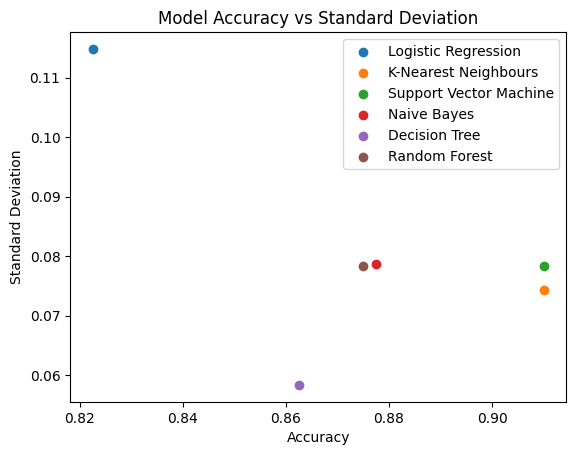

In [52]:
analyser.plot()